### 한글폰트

In [ ]:
!sudo apt-get update -qq # 폰트 설정을 위한 코드
!sudo apt-get install fonts-nanum* -qq
!sudo fc-cache -fv

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 39 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/nanum: skipping, looped dire

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 나눔 폰트 설치 경로 확인
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

# 폰트 매니저에 폰트 추가
font_prop = fm.FontProperties(fname=font_path)
plt.rc('font', family=font_prop.get_name())

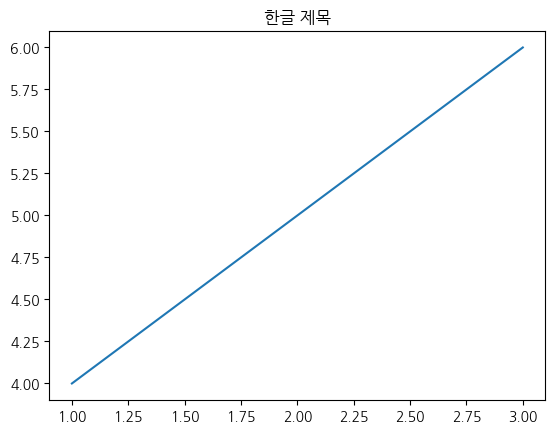

In [ ]:
import matplotlib.pyplot as plt

plt.plot([1, 2, 3], [4, 5, 6])
plt.title('한글 제목') # 한글 제목이 정상적으로 표시되는지 확인
plt.show()

## 데이터 다운로드

In [ ]:
!sudo apt-get update -qq # 폰트 설정을 위한 코드
!sudo apt-get install fonts-nanum* -qq
!sudo fc-cache -fv

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [3]:
! pwd

/content/drive/MyDrive


## 데이터 처리

In [4]:
import pandas as pd
import numpy as np

def add_conversation_to_train(
    train_data: pd.DataFrame,
    conv_csv_path: str,
    frac: float = 1.0,          # conversation.csv 중 사용할 비율 (0~1)
    shuffle: bool = True,
    random_state: int = 42,
    drop_dup_on_text: bool = False  # 텍스트 기준 중복 제거 여부
) -> pd.DataFrame:
    """
    conversation.csv에서 frac 비율만 샘플링해 train_data에 바로 합친다(디스크 저장 X).
    - idx 충돌 방지: 새로 추가되는 행들에 고유 idx를 부여해서 병합
    - 컬럼 정렬: train_data의 컬럼 순서를 기준으로 맞춤
    """

    # 1) conversation.csv 로드 (헤더 동일 가정)
    conv_df = pd.read_csv(conv_csv_path, index_col='idx')

    # 2) 컬럼 정렬/체크 (train_data 기준으로 맞춤)
    #    만약 순서가 다를 수 있으니 train_data.columns 순서로 재정렬
    missing_cols = [c for c in train_data.columns if c not in conv_df.columns]
    if missing_cols:
        raise ValueError(f"conversation.csv에 없는 컬럼: {missing_cols}")
    conv_df = conv_df[train_data.columns]

    # 3) 필요 비율만 샘플링
    if not (0.0 < frac <= 1.0):
        raise ValueError("frac 은 (0, 1] 범위여야 합니다.")
    if frac < 1.0:
        conv_df = conv_df.sample(frac=frac, random_state=random_state)

    # 4) (선택) 텍스트 중복 제거
    #    텍스트 컬럼명이 무엇인지 train_data에서 추정 (보통 'text' 또는 'conversation')
    text_col = None
    for c in train_data.columns:
        # 라벨 컬럼은 '일반 대화' 같은 값이므로 길이가 상대적으로 짧음 → 텍스트 후보는 문장 길이가 긴 문자열 컬럼
        if train_data[c].dtype == 'object':
            # 대충 평균 길이로 텍스트 후보를 heuristic 판단
            if train_data[c].astype(str).str.len().mean() > 15:
                text_col = c
                break
    # fallback: 첫 번째 object 컬럼을 텍스트로 가정
    if text_col is None:
        for c in train_data.columns:
            if train_data[c].dtype == 'object':
                text_col = c
                break

    if drop_dup_on_text and text_col is not None:
        # 기존 train과 새 conv 합쳐 중복 텍스트 제거 → 새로 추가할 것만 남김
        before = len(conv_df)
        conv_df = conv_df[~conv_df[text_col].isin(train_data[text_col])]
        # 필요하면 conv_df 내부 중복도 제거
        conv_df = conv_df.drop_duplicates(subset=[text_col], keep='first')
        print(f"[중복제거] 기존 {before} → 추가 대상 {len(conv_df)} (텍스트 기준)")

    if len(conv_df) == 0:
        print("[알림] 추가할 샘플이 없습니다.")
        return train_data

    # 5) idx 충돌 방지용 새 인덱스 생성
    #    - 숫자 인덱스면 max+1부터, 문자열이면 'g_000001' 시리즈
    def _make_new_idx(existing_index: pd.Index, n_new: int) -> pd.Index:
        if np.issubdtype(existing_index.dtype, np.number):
            start = (existing_index.max() + 1) if len(existing_index) > 0 else 0
            return pd.Index(range(start, start + n_new), name=existing_index.name or 'idx')
        else:
            start = len(existing_index)
            return pd.Index([f"g_{i:06d}" for i in range(start, start + n_new)],
                            name=existing_index.name or 'idx')

    new_idx = _make_new_idx(train_data.index, len(conv_df))
    conv_df = conv_df.copy()
    conv_df.index = new_idx

    # 6) (선택) 셔플
    if shuffle:
        conv_df = conv_df.sample(frac=1.0, random_state=random_state)

    # 7) 바로 메모리에서 concat (저장 X)
    merged = pd.concat([train_data, conv_df], axis=0)

    # 8) 정보 출력
    print(f"[merge] train: {len(train_data)}  +  add: {len(conv_df)}  ->  merged: {len(merged)}")
    return merged


In [5]:
import pandas as pd

# 데이터 읽기
train_data = pd.read_csv('data/training.csv', index_col='idx')
test_data = pd.read_csv('data/test.csv', index_col='idx')

# # conversation.csv에서 40%만 샘플링해서 추가 (텍스트 중복 제거 ON)
# train_data = add_conversation_to_train(
#     train_data,
#     conv_csv_path='data/conversations.csv',
#     frac=0.1,
#     shuffle=True,
#     random_state=42,
#     drop_dup_on_text=True
# )

# 데이터 증강 및 학습

In [6]:
!pip -q install sacremoses sentencepiece
# ---------------- 데이터 증강 ----------------
!pip install -q nlpaug

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 8.9 MB/s eta 0:00:00


In [7]:
# =========================================================
# KcBERT 5-클래스 대화 분류 (협박/갈취/직장괴롭힘/기타괴롭힘/일반)
# - Accelerate + AMP
# - 모델 max_position_embeddings 자동 반영
# - 학습/검증/저장/추론/제출/F1평가 통합
# - ★ Data Augmentation: "노이즈 추가(띄어쓰기/조사/경미한 오타/구두점)"
# =========================================================
import os, math, random, warnings, re
from collections import defaultdict
from typing import List, Sequence, Tuple

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")

# -----------------------------
# 0) Config
# -----------------------------
SEED = 42
MODEL_ID = "beomi/kcbert-base"       # ← KcBERT 체크포인트
FREEZE_ENCODER = True                # 인코더 동결(Linear Probe) 여부
REQ_MAX_LEN = 512                    # 사용자가 희망하는 최대 길이(모델 한계에 맞게 자동 축소됨)
EPOCHS = 40
LR = 3e-4 if FREEZE_ENCODER else 2e-5
WEIGHT_DECAY = 0.0 if FREEZE_ENCODER else 0.01
BATCH_TR = 64
BATCH_EV = 128
ACCUM_STEPS = 1
WARMUP_RATIO = 0.05
MAX_GRAD_NORM = 1.0

DATA_DIR = "data"
TRAIN_CSV = f"{DATA_DIR}/training.csv"   # columns: idx, conversation, class (라벨=문자열)
TEST_CSV  = f"{DATA_DIR}/test.csv"       # columns: idx, text  (혹은 conversation)
BEST_PATH = "kc_out/kcbert_best.safetensors"
OUT_DIR   = "kc_out"
SUBMIT_PATH = f"{DATA_DIR}/submission.csv"  # 생성될 제출 파일

# ----- Augmentation Config (노이즈 추가) -----
USE_AUG = True                # 증강 사용 여부
AUG_PROB = 0.6                # 각 샘플에서 증강 샘플을 1개 추가할 확률
AUG_APPLY_PROB_EACH = 0.5     # 개별 노이즈 연산을 적용할 확률(낮게 유지)
AUG_MAX_LEN_GUARD = 2048      # 과도한 길이 증가 방지 가드

# 라벨 정의(고정)
LABELS   = ['협박 대화','갈취 대화','직장 내 괴롭힘 대화','기타 괴롭힘 대화','일반 대화']
label2id = {l:i for i,l in enumerate(LABELS)}
id2label = {i:l for l,i in label2id.items()}

# -----------------------------
# 1) Reproducibility
# -----------------------------
def set_all_seeds(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    try:
        import torch
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    except Exception:
        pass

set_all_seeds(SEED)

# -----------------------------
# 2) Data Load
# -----------------------------
train_df = pd.read_csv(TRAIN_CSV, index_col="idx")
test_df  = pd.read_csv(TEST_CSV,  index_col="idx")

# 텍스트 컬럼 정규화
def pick_text_column(df: pd.DataFrame):
    for cand in ["text", "conversation", "utterance", "content"]:
        if cand in df.columns:
            return cand
    raise ValueError("텍스트 컬럼을 찾을 수 없습니다. (예상: text 또는 conversation)")

train_text_col = pick_text_column(train_df)
test_text_col  = pick_text_column(test_df)

# 라벨을 정수로 정규화
def to_label_ids(series: pd.Series) -> List[int]:
    vals = []
    for v in series:
        if isinstance(v, (int, np.integer)) or (isinstance(v, str) and v.isdigit()):
            vals.append(int(v))
        else:
            vals.append(label2id[str(v)])
    return vals

y_all = to_label_ids(train_df["class"])
x_all = train_df[train_text_col].astype(str).tolist()

# -----------------------------
# 3) Train/Valid stratified-skim split (class balance)
# -----------------------------
def make_balanced_split(x, y, val_size=0.15, random_state=SEED):
    rng = np.random.RandomState(random_state)
    x, y = np.array(x), np.array(y)
    class_indices = defaultdict(list)
    for i, label in enumerate(y):
        class_indices[label].append(i)
    min_class = min(len(idxs) for idxs in class_indices.values())
    n_val_each = max(1, int(round(val_size * min_class)))
    val_idx, train_idx = [], []
    for label, idxs in class_indices.items():
        idxs = rng.permutation(idxs)
        take = min(n_val_each, len(idxs)-1) if len(idxs) > 1 else 1
        val_idx.extend(idxs[:take])
        train_idx.extend(idxs[take:])
    return list(x[train_idx]), list(x[val_idx]), list(y[train_idx]), list(y[val_idx])

X_tr, X_val, y_tr, y_val = make_balanced_split(x_all, y_all, val_size=0.15, random_state=SEED)

# -----------------------------
# 3.5) Data Augmentation (노이즈 추가)
#    - 띄어쓰기 가감
#    - 조사 치환(을/를, 은/는, 이/가, 로/으로)
#    - 경미한 오타: 인접 문자 스왑/한 글자 드롭(낮은 확률)
#    - 구두점/반복부호 변형(.., !!!, ??)
#    ※ 의미 보존을 해치지 않도록 강도를 낮게 유지
# -----------------------------

_PARTICLE_SWAPS: List[Tuple[str, str]] = [
    (" 을 ", " 를 "), (" 를 ", " 을 "),
    (" 은 ", " 는 "), (" 는 ", " 은 "),
    (" 이 ", " 가 "), (" 가 ", " 이 "),
    (" 로 ", " 으로 "), (" 으로 ", " 로 "),
]

# 단어 경계에서만 적용하기 위해 앞뒤 공백/구두점을 보정
def _pad_for_particle(s: str) -> str:
    # 문장 앞뒤/구두점 경계에서 공백을 보정하여 안전 치환
    s = re.sub(r"([^\w가-힣])", r" \1 ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return f" {s} "

def _unpad_particle(s: str) -> str:
    s = re.sub(r"\s+", " ", s)
    s = s.strip()
    return s

def aug_particles(s: str) -> str:
    t = _pad_for_particle(s)
    # 몇 개만 무작위 치환
    random.shuffle(_PARTICLE_SWAPS)
    for a, b in _PARTICLE_SWAPS[: random.randint(1, 2)]:
        if random.random() < AUG_APPLY_PROB_EACH:
            t = t.replace(a, b)
    return _unpad_particle(t)

def aug_spacing(s: str) -> str:
    # 토큰 기준 랜덤 공백 삽입/제거(경미)
    toks = re.split(r"(\s+)", s)
    out = []
    for tok in toks:
        if tok.isspace():
            # 공백을 유지/제거/늘리기
            r = random.random()
            if r < 0.15:
                continue
            elif r < 0.30:
                out.append("  ")
            else:
                out.append(" ")
        else:
            out.append(tok)
            # 단어 뒤에 확률적으로 공백 추가
            if random.random() < 0.05:
                out.append(" ")
    s2 = "".join(out)
    return re.sub(r"\s+", " ", s2).strip()

def aug_local_typo(s: str) -> str:
    # 길이가 5~60 사이인 '단어' 하나 골라서 경미한 스왑/드롭 적용
    words = re.findall(r"[가-힣\w]{2,}", s)
    if not words:
        return s
    w = random.choice(words)
    w2 = w
    if len(w) >= 3 and random.random() < 0.6:
        # 인접 문자 스왑
        i = random.randint(0, len(w)-2)
        w2 = w[:i] + w[i+1] + w[i] + w[i+2:]
    else:
        # 한 글자 드롭
        i = random.randint(0, len(w)-1)
        w2 = w[:i] + w[i+1:]
    if w2 == w:
        return s
    return s.replace(w, w2, 1)

def aug_punct(s: str) -> str:
    # 구두점 변형: 마침표/물음표/느낌표 반복 등
    s = s.replace("...", "..")
    s = re.sub(r"([.!?])\1{2,}", r"\1\1", s)  # 과도한 반복 축소
    # 확률적으로 종결부 변형
    if random.random() < AUG_APPLY_PROB_EACH:
        s = re.sub(r"[.!?]+$", "", s).strip()
        s += random.choice([".", "..", "!", "!!", "?", "??"])
    return s

def make_noisy_variant(s: str) -> str:
    t = s
    # 적용 순서는 영향도가 낮은 것부터
    if random.random() < AUG_APPLY_PROB_EACH:
        t = aug_spacing(t)
    if random.random() < AUG_APPLY_PROB_EACH:
        t = aug_particles(t)
    if random.random() < 0.25:  # 오타는 낮은 확률
        t = aug_local_typo(t)
    if random.random() < AUG_APPLY_PROB_EACH:
        t = aug_punct(t)
    # 길이 가드
    if len(t) > AUG_MAX_LEN_GUARD:
        t = t[:AUG_MAX_LEN_GUARD]
    return t

def build_augmented_lists(X: List[str], y: List[int]) -> Tuple[List[str], List[int]]:
    if not USE_AUG:
        return X, y
    X_out, y_out = [], []
    for xi, yi in zip(X, y):
        X_out.append(xi)
        y_out.append(yi)
        if random.random() < AUG_PROB:
            noisy = make_noisy_variant(xi)
            # 동일 라벨로 추가
            X_out.append(noisy)
            y_out.append(yi)
    return X_out, y_out

X_tr, y_tr = build_augmented_lists(list(X_tr), list(y_tr))

# -----------------------------
# 4) HF / Accelerate 준비
# -----------------------------
try:
    import torch, transformers, accelerate, datasets, safetensors  # noqa
except Exception:
    import subprocess, sys
    subprocess.check_call([sys.executable, "-m", "pip", "install",
                           "torch>=2.1", "transformers>=4.41", "accelerate>=0.30",
                           "datasets>=2.19", "safetensors>=0.4", "scikit-learn"])

import torch
from torch import nn
from torch.utils.data import DataLoader
from datasets import Dataset
from accelerate import Accelerator
from accelerate.utils import ProjectConfiguration
from safetensors.torch import save_file, load_file
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          DataCollatorWithPadding, get_linear_schedule_with_warmup)

# Accelerator 초기화
def init_accelerator(accum_steps: int) -> Accelerator:
    if torch.cuda.is_available():
        mp = "bf16" if torch.cuda.is_bf16_supported() else "fp16"
    else:
        mp = "no"
    proj = ProjectConfiguration(project_dir=OUT_DIR, logging_dir=os.path.join(OUT_DIR, "logs"))
    return Accelerator(gradient_accumulation_steps=accum_steps,
                       project_config=proj,
                       mixed_precision=(None if mp=="no" else mp))

accelerator = init_accelerator(ACCUM_STEPS)
device = accelerator.device
if accelerator.is_local_main_process:
    print(f"[INFO] device={device} | mp={accelerator.mixed_precision}")

# -----------------------------
# 5) Tokenizer / Model 로드
#    (모델 최대 길이에 맞춰 MAX_LEN 자동 설정)
# -----------------------------
tok = AutoTokenizer.from_pretrained(MODEL_ID, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_ID, num_labels=len(LABELS), id2label=id2label, label2id=label2id
)

MODEL_MAX_POS = int(getattr(model.config, "max_position_embeddings", 512))
MAX_LEN = min(REQ_MAX_LEN, MODEL_MAX_POS)  # ← 핵심: 모델 한계 반영
tok.model_max_length = MAX_LEN

if accelerator.is_local_main_process:
    print(f"[INFO] model max_position_embeddings={MODEL_MAX_POS} → using MAX_LEN={MAX_LEN}")

# 인코더 동결
if FREEZE_ENCODER:
    base = (getattr(model, "bert", None)
            or getattr(model, "electra", None)
            or getattr(model, "roberta", None)
            or getattr(model, "base_model", None))
    if base is not None:
        for p in base.parameters():
            p.requires_grad = False

# -----------------------------
# 6) HF Datasets 구성
# -----------------------------
def _to_list(x: Sequence):
    if hasattr(x, "tolist"):
        try: return x.tolist()
        except Exception: pass
    return list(x)

X_tr, X_val, y_tr, y_val = _to_list(X_tr), _to_list(X_val), _to_list(y_tr), _to_list(y_val)

train_ds = Dataset.from_dict({"text": X_tr, "label": y_tr})
valid_ds = Dataset.from_dict({"text": X_val, "label": y_val})

def preprocess(batch):
    return tok(batch["text"], truncation=True, max_length=MAX_LEN)

# num_proc은 로컬 환경에 맞게 자동/수동 조절
try:
    train_ds = train_ds.map(preprocess, batched=True, remove_columns=["text"], num_proc=4)
    valid_ds = valid_ds.map(preprocess, batched=True, remove_columns=["text"], num_proc=4)
except Exception:
    train_ds = train_ds.map(preprocess, batched=True, remove_columns=["text"])
    valid_ds = valid_ds.map(preprocess, batched=True, remove_columns=["text"])

collator = DataCollatorWithPadding(tokenizer=tok, padding="longest")

# 클래스 가중치(선택)
counts = np.bincount(y_tr, minlength=len(LABELS))
w = counts.sum() / np.clip(counts, 1, None)
w = w / w.mean()
criterion = nn.CrossEntropyLoss(weight=torch.tensor(w, dtype=torch.float))

optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                              lr=LR, weight_decay=WEIGHT_DECAY)

num_workers = 4 if torch.cuda.is_available() else 0
loader_kwargs = dict(num_workers=num_workers,
                     pin_memory=bool(torch.cuda.is_available()),
                     persistent_workers=bool(torch.cuda.is_available()) and num_workers > 0)

train_loader = DataLoader(train_ds, batch_size=BATCH_TR, shuffle=True,  collate_fn=collator, **loader_kwargs)
valid_loader = DataLoader(valid_ds, batch_size=BATCH_EV, shuffle=False, collate_fn=collator, **loader_kwargs)

steps_per_epoch = math.ceil(len(train_loader) / ACCUM_STEPS)
num_training_steps = EPOCHS * steps_per_epoch
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(WARMUP_RATIO * num_training_steps),
    num_training_steps=num_training_steps
)

# AMP 설정
use_amp   = (device.type == "cuda")
amp_dtype = torch.bfloat16 if (use_amp and torch.cuda.is_bf16_supported()) else torch.float16
use_scaler= (use_amp and amp_dtype == torch.float16)
scaler    = torch.cuda.amp.GradScaler(enabled=use_scaler)

# Accelerate 준비
model, optimizer, train_loader, valid_loader, scheduler = accelerator.prepare(
    model, optimizer, train_loader, valid_loader, scheduler
)
criterion = criterion.to(device)

# -----------------------------
# 7) 평가 함수
# -----------------------------
def evaluate():
    model.eval()
    preds_all, labels_all = [], []
    with torch.no_grad():
        for batch in valid_loader:
            labels = batch.pop("labels").to(device, non_blocking=True)
            inputs = {k: v.to(device, non_blocking=True) for k, v in batch.items()}
            with torch.autocast(device_type="cuda", dtype=amp_dtype, enabled=use_amp):
                logits = model(**inputs).logits
                preds  = logits.argmax(dim=1)
            preds_all.append(accelerator.gather_for_metrics(preds))
            labels_all.append(accelerator.gather_for_metrics(labels))
    y_hat  = torch.cat(preds_all).cpu().numpy()
    y_true = torch.cat(labels_all).cpu().numpy()
    acc = accuracy_score(y_true, y_hat)
    mf1 = f1_score(y_true, y_hat, average="macro")
    return acc, mf1, y_true, y_hat

# -----------------------------
# 8) 학습 루프
# -----------------------------
os.makedirs(OUT_DIR, exist_ok=True)
best_mf1 = -1.0

for epoch in range(1, EPOCHS + 1):
    model.train()
    running = 0.0
    pbar = tqdm(train_loader, disable=not accelerator.is_local_main_process,
                desc=f"Epoch {epoch}/{EPOCHS}")
    for step, batch in enumerate(pbar, start=1):
        with accelerator.accumulate(model):
            labels = batch.pop("labels").to(device, non_blocking=True)
            inputs = {k: v.to(device, non_blocking=True) for k, v in batch.items()}

            if use_scaler:
                with torch.autocast(device_type="cuda", dtype=amp_dtype, enabled=True):
                    logits = model(**inputs).logits
                    loss = criterion(logits, labels)
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                accelerator.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)
                scheduler.step()
            else:
                with torch.autocast(device_type="cuda", dtype=amp_dtype, enabled=use_amp):
                    logits = model(**inputs).logits
                    loss = criterion(logits, labels)
                accelerator.backward(loss)
                accelerator.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
                optimizer.step()
                optimizer.zero_grad(set_to_none=True)
                scheduler.step()

            running += loss.detach().float().item()
            if accelerator.is_local_main_process:
                pbar.set_postfix(loss=round(running/step, 4))

    acc, mf1, y_true, y_hat = evaluate()
    if accelerator.is_local_main_process:
        print(f"[Eval] epoch={epoch} acc={acc:.4f} macroF1={mf1:.4f}")
        if mf1 > best_mf1:
            best_mf1 = mf1
            state = accelerator.get_state_dict(model)
            save_file(state, BEST_PATH)
            print(f"  ↳ New best saved to {BEST_PATH}")

# -----------------------------
# 9) Best 복원 & 최종 검증 리포트
# -----------------------------
if accelerator.is_local_main_process:
    try:
        state = load_file(BEST_PATH)
        model.load_state_dict(state, strict=False)
    except Exception as e:
        print(f"[WARN] best ckpt load failed (use last weights): {e}")

    acc, mf1, y_true, y_hat = evaluate()
    print("Final Accuracy:", acc)
    print("Final Macro-F1:", mf1)
    print(pd.DataFrame(
        classification_report(y_true, y_hat, target_names=LABELS, digits=4, output_dict=True)
    ).T)
    print("Confusion matrix:\n", confusion_matrix(y_true, y_hat))

# -----------------------------
# 10) 추론/제출 파일 생성
# -----------------------------
def infer(texts: List[str], batch_size: int = 64) -> List[str]:
    if isinstance(texts, str):
        texts = [texts]
    model.eval()
    preds = []
    for i in range(0, len(texts), batch_size):
        chunk = texts[i:i+batch_size]
        batch = tok(chunk, truncation=True, padding=True,
                    max_length=MAX_LEN, return_tensors="pt")
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad(), torch.autocast(device_type="cuda", dtype=amp_dtype, enabled=(device.type=="cuda")):
            logits = model(**batch).logits
            ids = logits.argmax(dim=1).cpu().tolist()
            preds.extend(ids)
    return [LABELS[i] for i in preds]

if accelerator.is_local_main_process:
    # test 텍스트 준비
    test_texts = test_df[test_text_col].astype(str).tolist()
    pred_labels = infer(test_texts, batch_size=BATCH_EV)
    # 제출: idx, target(정수)
    pred_ids = [label2id[lbl] for lbl in pred_labels]
    submission = pd.DataFrame({"idx": test_df.index.astype(str), "target": pred_ids})
    submission.to_csv(SUBMIT_PATH, index=False, encoding="utf-8-sig")
    print(f"[OK] submission saved → {SUBMIT_PATH}")

    # (선택) 정답 파일이 있으면 F1 계산
    ANS_PATH = f"{DATA_DIR}/test_answer.csv"
    if os.path.exists(ANS_PATH):
        ans = pd.read_csv(ANS_PATH)
        # 키 매칭: submission.idx ↔ test_answer.file_name
        ans["key"] = ans["file_name"].astype(str).str.strip()
        submission["key"] = submission["idx"].astype(str).str.strip()
        merged = ans.merge(submission, on="key", how="inner")
        def coerce_to_int(s: pd.Series) -> np.ndarray:
            out = []
            for x in s.astype(str).str.strip():
                if x.isdigit():
                    out.append(int(x))
                else:
                    out.append(label2id.get(x, np.nan))
            arr = np.array(out, dtype=float)
            ok = ~np.isnan(arr)
            return ok, arr[ok].astype(int)

        ok1, y_true = coerce_to_int(merged["class"])
        ok2, y_pred = coerce_to_int(merged["target"])
        ok = ok1 & ok2
        y_true = y_true[ok]
        y_pred = y_pred[ok]
        if len(y_true) > 0:
            macro_f1 = f1_score(y_true, y_pred, average="macro")
            micro_f1 = f1_score(y_true, y_pred, average="micro")
            weighted_f1 = f1_score(y_true, y_pred, average="weighted")
            print(f"[Test Answer] compared samples(실제와의 오차 : +-0.05 정도): {len(y_true)}")
            print(f"Macro F1 : {macro_f1:.6f}")
            print(f"Micro F1 : {micro_f1:.6f}")
            print(f"Weighted F1 : {weighted_f1:.6f}")
        else:
            print("[Test Answer] 교집합이 없어 F1을 계산할 수 없습니다.")


[INFO] device=cuda | mp=bf16


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/619 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at beomi/kcbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[INFO] model max_position_embeddings=300 → using MAX_LEN=300


Map (num_proc=4):   0%|          | 0/6870 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/670 [00:00<?, ? examples/s]

Epoch 1/40:   0%|          | 0/108 [00:00<?, ?it/s]

[Eval] epoch=1 acc=0.3776 macroF1=0.3464
  ↳ New best saved to kc_out/kcbert_best.safetensors


Epoch 2/40:   0%|          | 0/108 [00:00<?, ?it/s]

[Eval] epoch=2 acc=0.5313 macroF1=0.5288
  ↳ New best saved to kc_out/kcbert_best.safetensors


Epoch 3/40:   0%|          | 0/108 [00:00<?, ?it/s]

[Eval] epoch=3 acc=0.7627 macroF1=0.7556
  ↳ New best saved to kc_out/kcbert_best.safetensors


Epoch 4/40:   0%|          | 0/108 [00:00<?, ?it/s]

[Eval] epoch=4 acc=0.8000 macroF1=0.7961
  ↳ New best saved to kc_out/kcbert_best.safetensors


Epoch 5/40:   0%|          | 0/108 [00:00<?, ?it/s]

[Eval] epoch=5 acc=0.7896 macroF1=0.7795


Epoch 6/40:   0%|          | 0/108 [00:00<?, ?it/s]

[Eval] epoch=6 acc=0.8030 macroF1=0.7961


Epoch 7/40:   0%|          | 0/108 [00:00<?, ?it/s]

[Eval] epoch=7 acc=0.7940 macroF1=0.7859


Epoch 8/40:   0%|          | 0/108 [00:00<?, ?it/s]

[Eval] epoch=8 acc=0.8119 macroF1=0.8080
  ↳ New best saved to kc_out/kcbert_best.safetensors


Epoch 9/40:   0%|          | 0/108 [00:00<?, ?it/s]

[Eval] epoch=9 acc=0.8328 macroF1=0.8288
  ↳ New best saved to kc_out/kcbert_best.safetensors


Epoch 10/40:   0%|          | 0/108 [00:00<?, ?it/s]

[Eval] epoch=10 acc=0.8299 macroF1=0.8250


Epoch 11/40:   0%|          | 0/108 [00:00<?, ?it/s]

[Eval] epoch=11 acc=0.8269 macroF1=0.8227


Epoch 12/40:   0%|          | 0/108 [00:00<?, ?it/s]

[Eval] epoch=12 acc=0.8463 macroF1=0.8432
  ↳ New best saved to kc_out/kcbert_best.safetensors


Epoch 13/40:   0%|          | 0/108 [00:00<?, ?it/s]

[Eval] epoch=13 acc=0.8358 macroF1=0.8320


Epoch 14/40:   0%|          | 0/108 [00:00<?, ?it/s]

[Eval] epoch=14 acc=0.8358 macroF1=0.8326


Epoch 15/40:   0%|          | 0/108 [00:00<?, ?it/s]

[Eval] epoch=15 acc=0.8403 macroF1=0.8374


Epoch 16/40:   0%|          | 0/108 [00:00<?, ?it/s]

[Eval] epoch=16 acc=0.8448 macroF1=0.8419


Epoch 17/40:   0%|          | 0/108 [00:00<?, ?it/s]

[Eval] epoch=17 acc=0.8388 macroF1=0.8364


Epoch 18/40:   0%|          | 0/108 [00:00<?, ?it/s]

[Eval] epoch=18 acc=0.8403 macroF1=0.8381


Epoch 19/40:   0%|          | 0/108 [00:00<?, ?it/s]

[Eval] epoch=19 acc=0.8418 macroF1=0.8398


Epoch 20/40:   0%|          | 0/108 [00:00<?, ?it/s]

[Eval] epoch=20 acc=0.8433 macroF1=0.8395


Epoch 21/40:   0%|          | 0/108 [00:00<?, ?it/s]

[Eval] epoch=21 acc=0.8433 macroF1=0.8414


Epoch 22/40:   0%|          | 0/108 [00:00<?, ?it/s]

[Eval] epoch=22 acc=0.8433 macroF1=0.8406


Epoch 23/40:   0%|          | 0/108 [00:00<?, ?it/s]

[Eval] epoch=23 acc=0.8448 macroF1=0.8414


Epoch 24/40:   0%|          | 0/108 [00:00<?, ?it/s]

[Eval] epoch=24 acc=0.8448 macroF1=0.8428


Epoch 25/40:   0%|          | 0/108 [00:00<?, ?it/s]

[Eval] epoch=25 acc=0.8433 macroF1=0.8409


Epoch 26/40:   0%|          | 0/108 [00:00<?, ?it/s]

[Eval] epoch=26 acc=0.8507 macroF1=0.8513
  ↳ New best saved to kc_out/kcbert_best.safetensors


Epoch 27/40:   0%|          | 0/108 [00:00<?, ?it/s]

[Eval] epoch=27 acc=0.8448 macroF1=0.8427


Epoch 28/40:   0%|          | 0/108 [00:00<?, ?it/s]

[Eval] epoch=28 acc=0.8522 macroF1=0.8502


Epoch 29/40:   0%|          | 0/108 [00:00<?, ?it/s]

[Eval] epoch=29 acc=0.8507 macroF1=0.8484


Epoch 30/40:   0%|          | 0/108 [00:00<?, ?it/s]

[Eval] epoch=30 acc=0.8493 macroF1=0.8486


Epoch 31/40:   0%|          | 0/108 [00:00<?, ?it/s]

[Eval] epoch=31 acc=0.8493 macroF1=0.8465


Epoch 32/40:   0%|          | 0/108 [00:00<?, ?it/s]

[Eval] epoch=32 acc=0.8463 macroF1=0.8449


Epoch 33/40:   0%|          | 0/108 [00:00<?, ?it/s]

[Eval] epoch=33 acc=0.8567 macroF1=0.8541
  ↳ New best saved to kc_out/kcbert_best.safetensors


Epoch 34/40:   0%|          | 0/108 [00:00<?, ?it/s]

[Eval] epoch=34 acc=0.8537 macroF1=0.8513


Epoch 35/40:   0%|          | 0/108 [00:00<?, ?it/s]

[Eval] epoch=35 acc=0.8448 macroF1=0.8430


Epoch 36/40:   0%|          | 0/108 [00:00<?, ?it/s]

[Eval] epoch=36 acc=0.8537 macroF1=0.8518


Epoch 37/40:   0%|          | 0/108 [00:00<?, ?it/s]

[Eval] epoch=37 acc=0.8537 macroF1=0.8511


Epoch 38/40:   0%|          | 0/108 [00:00<?, ?it/s]

[Eval] epoch=38 acc=0.8522 macroF1=0.8499


Epoch 39/40:   0%|          | 0/108 [00:00<?, ?it/s]

[Eval] epoch=39 acc=0.8522 macroF1=0.8500


Epoch 40/40:   0%|          | 0/108 [00:00<?, ?it/s]

[Eval] epoch=40 acc=0.8507 macroF1=0.8484
Final Accuracy: 0.8567164179104477
Final Macro-F1: 0.854134590592951
              precision    recall  f1-score     support
협박 대화          0.835714  0.873134  0.854015  134.000000
갈취 대화          0.796992  0.791045  0.794007  134.000000
직장 내 괴롭힘 대화    0.868056  0.932836  0.899281  134.000000
기타 괴롭힘 대화      0.830357  0.694030  0.756098  134.000000
일반 대화          0.943262  0.992537  0.967273  134.000000
accuracy       0.856716  0.856716  0.856716    0.856716
macro avg      0.854876  0.856716  0.854135  670.000000
weighted avg   0.854876  0.856716  0.854135  670.000000
Confusion matrix:
 [[117   9   3   4   1]
 [ 12 106   4  10   2]
 [  1   3 125   4   1]
 [ 10  15  12  93   4]
 [  0   0   0   1 133]]
[OK] submission saved → data/submission.csv
[Test Answer] compared samples: 500
Macro F1 : 0.628514
Micro F1 : 0.648000
Weighted F1 : 0.625278


In [14]:
# 사용 예:
infer(["핸드폰 빌려 주실 수 있어요? 네? 급하시면 1통화 하세요 감사합니다 어? 제가 깨트린거 아니에요 니가 빌려달라고 하고 니가 깨트렸잖아 아니라구요 님이 깨트렸잖아요 이거 완전 사기꾼이네. 당장 액정 값 내놔 사기꾼은 당신이지. 한두번 해본 솜씨가 아니구만 이 새끼야 니 핸드폰이라도 가져간다. 뭐하는거야? 당신! 돌려줘 꺼져 이제부터 이거 내 꺼야.", "오늘 회의는 3시에 시작한다고!"])

['갈취 대화', '일반 대화']

## 데이터 길이, 클래스 분포 확인